In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file = "results.csv"
sep = ","
enc = "utf-8"

df = pd.read_csv(file, sep=sep, header=0, encoding=enc)

In [3]:
gt_df = pd.read_csv("number_gtos.csv", sep=" ", encoding=enc)
gt_df.columns = ["id", "|Omega|"]

In [4]:
knns = [10, 25, 45]
reg_strengths = [0.03, 0.07, 0.1, 0.3, 0.7]

cp_args = list(itertools.product(*[reg_strengths, knns]))
n_cp_args = len(cp_args)

stat_cols = [
        "|V|", # nr of vertices
        "|T|", # nr of triangles
        "|S_M|", # nr of superpoints in the mesh partition
        "|E_M|", # nr of superedges in the mesh superpoint graph
        "OOA_M", # overall object accuracy of the mesh
        "|S_M_k|", # nr of superpoints in the mesh partition
        "|E_M_k|", # nr of superedges in the mesh superpoint graph
        "OOA_M_k", # overall object accuracy of the mesh
        "|S_P|", # nr of superpoints in the point cloud partition
        "|E_P|", # nr of superedges in the point cloud superpoint graph
        "OOA_P", # overall object accuracy of the point cloud
        "mean(n)", # average number of neighbours per vertex
        "std(n)", # std of neighbours per vertex
        "median(n)", # median of neighbours per vertex
        "|Omega|" # number of ground truth objects
        ]

def get_ratio(stat_df, col_sp, col_ooa):
    l1 = stat_df.loc[:, col_sp] / stat_df.loc[:, "|Omega|"]
    l2 = stat_df.loc[:, "|Omega|"] / stat_df.loc[:, col_sp]
    L = pd.concat((l1, l2), axis=1).max(axis=1)
    r = stat_df.loc[:, col_ooa] / L
    return r

stats_list = n_cp_args * [None]
for i in range(n_cp_args):
    reg_strength, knn = cp_args[i]
    tmp_df = df[(df["lambda"] == reg_strength) & (df["knn"] == knn)]
    
    tmp_df = pd.merge(tmp_df, gt_df, how ="inner", on =["id"])
    
    stat_df = tmp_df.loc[:, stat_cols]
    
    ratio_M = get_ratio(stat_df=stat_df, col_sp="|S_M|", col_ooa="OOA_M")
    ratio_M_k = get_ratio(stat_df=stat_df, col_sp="|S_M_k|", col_ooa="OOA_M_k")  
    ratio_P = get_ratio(stat_df=stat_df, col_sp="|S_P|", col_ooa="OOA_P")    
    
    rf = pd.DataFrame(data=[ratio_M, ratio_P, ratio_M_k]).transpose()
    rf.columns = ["r_M", "r_P", "r_M_k"]
    
    stat_df_ = pd.concat([stat_df, rf], axis=1)
    
    mean_stat = stat_df_.mean(axis=0)
    std_stat = stat_df_.std(axis=0)
    median_stat = stat_df_.median(axis=0)
    
    stats = pd.concat([mean_stat, std_stat, median_stat], axis=1).transpose()
    #index_str = "_{0:.3f}_{1}".format(reg_strength, knn)
    #stats.index = ["mean" + index_str, "std" + index_str, "median" + index_str]
    stats.index = ["mean", "std", "median"]
    stats_t = ((reg_strength, knn), stats)
    stats_list[i] = stats_t

In [5]:
x = np.arange(n_cp_args, dtype=np.uint32)

In [6]:
rs_list = n_cp_args * [None]
s_list = n_cp_args * [None]
ooa_list = n_cp_args * [None]
params_list = n_cp_args * [None]
for i in range(n_cp_args):
    stats_t = stats_list[i]
    params = stats_t[0]
    stats = stats_t[1]
    param_str = "{0:.3f},{1}".format(params[0], params[1])
    params_list[i] = param_str
    r_stats = stats.loc["mean", ["r_M", "r_P", "r_M_k"]]
    rs = r_stats.to_list()
    rs_list[i] = rs
    s = stats.loc["mean", ["|S_M|", "|S_P|", "|S_M_k|"]]
    s_list[i] = s
    ooa = stats.loc["mean", ["OOA_M", "OOA_P", "OOA_M_k"]]
    ooa_list[i] = ooa
ratios = np.array(rs_list)
sizes = np.array(s_list)
log_sizes = np.log10(sizes)
ooas = np.array(ooa_list)

In [7]:
def plot(x, y, ylabel, labels, xticks, title):
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(8)
    plt.rc("font", size=20)
    for i in range(y.shape[1]):
        plt.plot(x, y[:, i], "--x", label=labels[i])
    plt.legend()
    plt.xticks(x, xticks, rotation="vertical")
    #plt.title(title)
    plt.ylabel(ylabel)

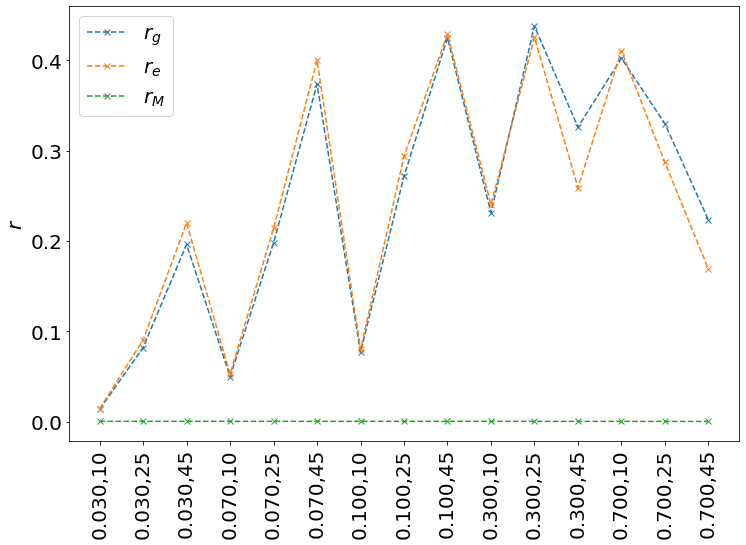

In [8]:
plot(x=x, y=ratios, ylabel=r"$r$", labels=[r"$r_g$", r"$r_e$", r"$r_M$"], xticks=params_list, title=r"ratio $r$")
plt.savefig("ratio.png", bbox_inches="tight")

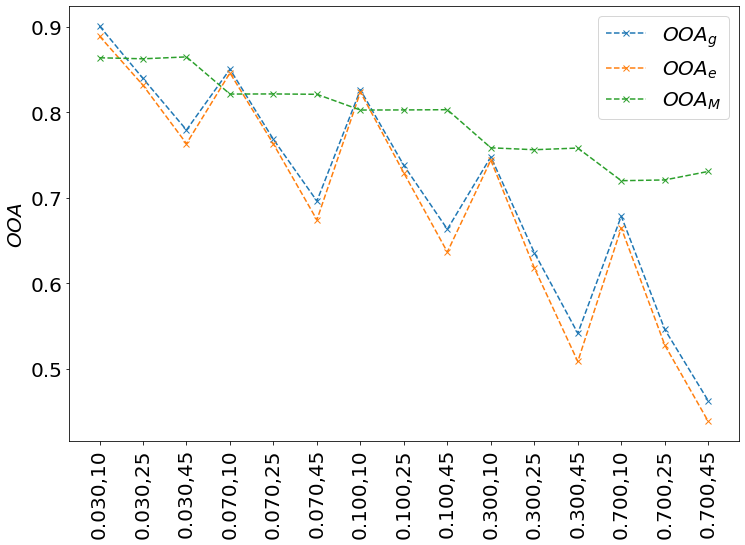

In [9]:
plot(x=x, y=ooas, ylabel=r"$OOA$", labels=[r"$OOA_g$", r"$OOA_e$", r"$OOA_{M}$"],
     xticks=params_list, title=r"Overall Object Accuracy ($OOA$)")
plt.savefig("ooa.png", bbox_inches="tight")

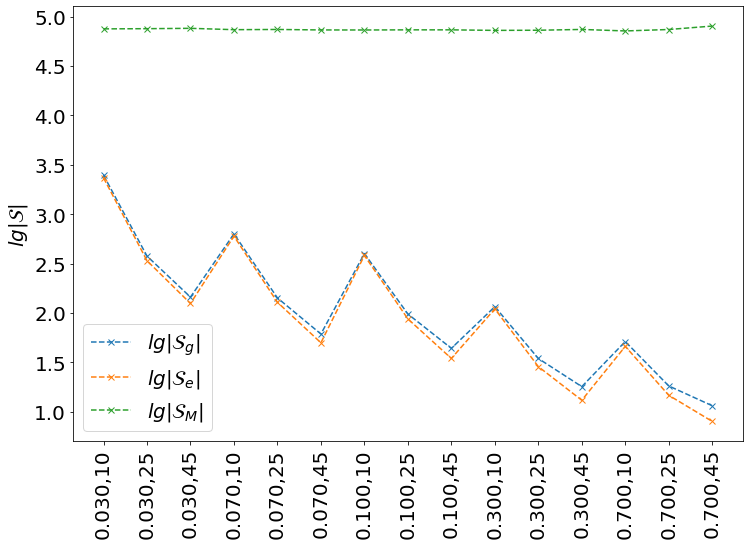

In [10]:
plot(x=x, y=log_sizes, ylabel=r"$lg|\mathcal{S}|$",
     labels=[r"$lg|\mathcal{S}_g|$", r"$lg|\mathcal{S}_e|$", r"$lg|\mathcal{S}_{M}|$"],
     xticks=params_list, title=r"log of the partition sizes $lg|\mathcal{S}|$")
plt.savefig("log_sizes.png", bbox_inches="tight")

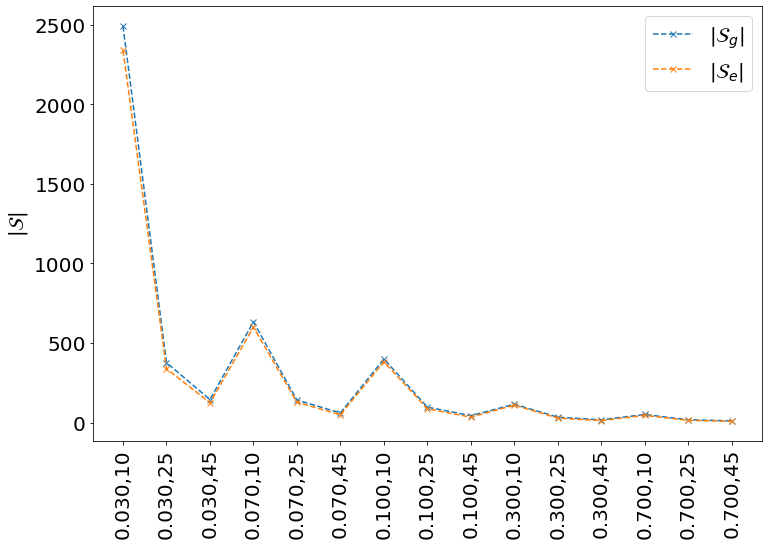

In [11]:
plot(x=x, y=sizes[:, :2], ylabel=r"$|\mathcal{S}|$", labels=[r"$|\mathcal{S}_g|$", r"$|\mathcal{S}_e|$"],
     xticks=params_list, title=r"$|\mathcal{S}|$")